2025-09-26 12:23:46.194638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758889426.474086      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758889426.556203      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


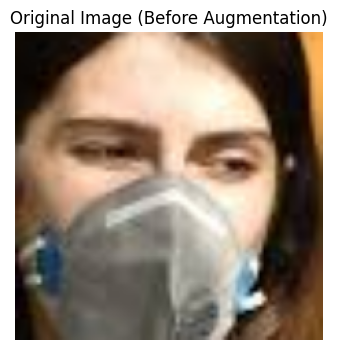

🔹 Augmenting and saving training images...


100%|██████████| 1558/1558 [01:14<00:00, 20.88it/s]


🔹 Saving validation and test images...

 All images saved at: /kaggle/working/Aug_Dataset


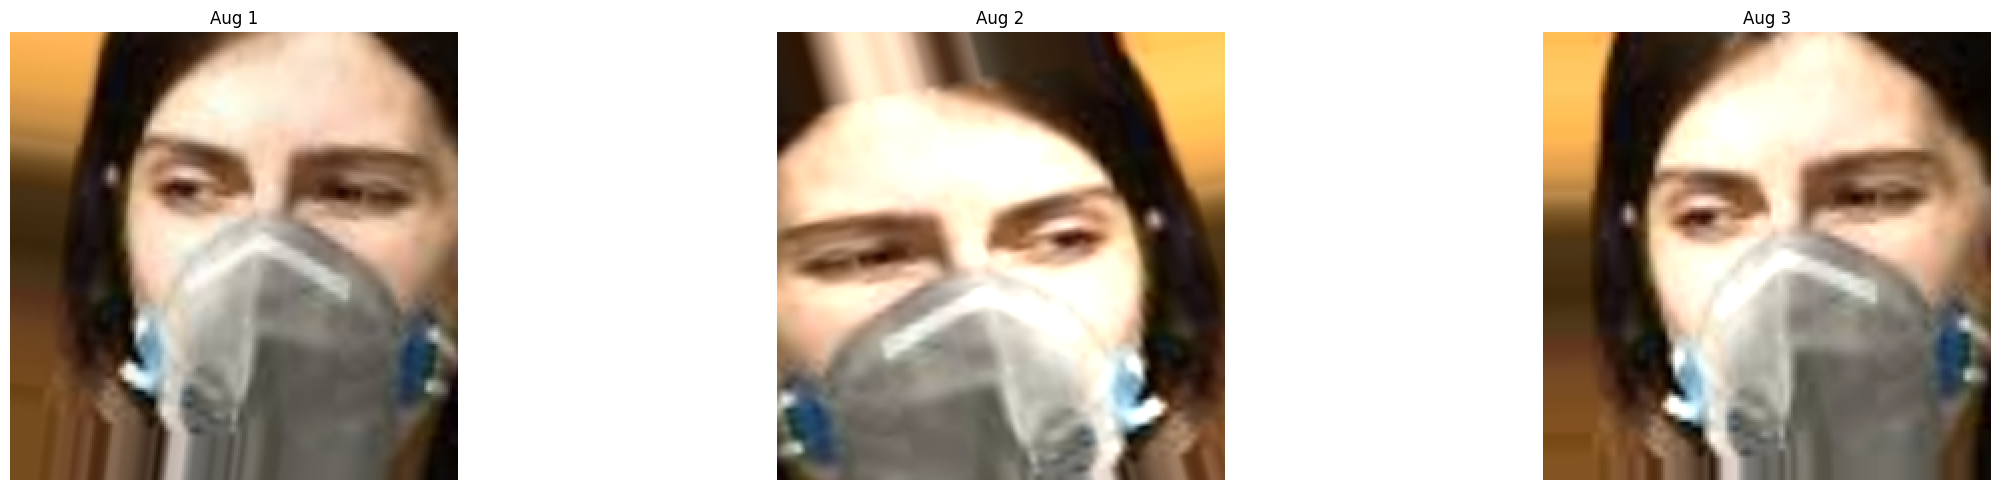

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# Paths

split_path = "/kaggle/input/trainvaltestsplit"   
output_base = "/kaggle/working/Aug_Dataset"
splits = ["Train", "Validation", "Test"]
categories = ["WithMask", "WithoutMask"]

for split in splits:
    for category in categories:
        os.makedirs(os.path.join(output_base, split, category), exist_ok=True)


# Load file paths + labels

def load_split_files(split_name):
    files, labels = [], []
    for category in categories:
        folder = os.path.join(split_path, split_name, category)
        file_list = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".npy")]
        files.extend(file_list)
        labels.extend([1 if category == "WithMask" else 0] * len(file_list))
    return np.array(files), np.array(labels)

X_train, y_train = load_split_files("Train")
X_val, y_val     = load_split_files("Validation")
X_test, y_test   = load_split_files("Test")


# Augmentation Config

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


# Example Image for Preview

sample_index = 0
sample_file = X_train[sample_index]
sample_label = y_train[sample_index]
sample_category = "WithMask" if sample_label == 1 else "WithoutMask"

sample_img_data = np.load(sample_file)
sample_img_display = ((sample_img_data + 1.0) * 127.5).astype(np.uint8)

plt.figure(figsize=(4, 4))
plt.imshow(sample_img_display)
plt.title("Original Image (Before Augmentation)")
plt.axis('off')
plt.show()


# Augment and Save Training Data

print("🔹 Augmenting and saving training images...")
for i in tqdm(range(len(X_train))):
    img_data = np.load(X_train[i])
    img = img_data.reshape((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    label = y_train[i]
    category = "WithMask" if label == 1 else "WithoutMask"

    for j, batch in enumerate(datagen.flow(img, batch_size=1)):
        save_path = os.path.join(output_base, "Train", category, f"img_{i}_aug{j}.npy")
        np.save(save_path, batch[0])
        if j == 2:  # 3 augmentations per image
            break


# Save Validation and Test (No Augmentation)

print("🔹 Saving validation and test images...")
for X_set, y_set, split_name in zip([X_val, X_test], [y_val, y_test], ["Validation", "Test"]):
    for j in range(len(X_set)):
        img_data = np.load(X_set[j])
        label = y_set[j]
        category = "WithMask" if label == 1 else "WithoutMask"
        save_path = os.path.join(output_base, split_name, category, f"img_{j}.npy")
        np.save(save_path, img_data)

print(f"\n All images saved at: {output_base}")


# Display Augmented Samples

category_folder = os.path.join(output_base, "Train", sample_category)
base_prefix = f"img_{sample_index}_aug"
augmented_images = sorted([img for img in os.listdir(category_folder) if img.startswith(base_prefix)])

plt.figure(figsize=(25, 5))
for i, img_name in enumerate(augmented_images[:3]):
    img_path = os.path.join(category_folder, img_name)
    img_data = np.load(img_path)
    img_display = ((img_data + 1.0) * 127.5).astype(np.uint8)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_display)
    plt.title(f"Aug {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import zipfile


zip_path = "/kaggle/working/FinalDataset.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_base):
        for file in files:
            abs_path = os.path.join(root, file)
            rel_path = os.path.relpath(abs_path, output_base)
            zipf.write(abs_path, rel_path)

# Print success message
print(f"\n Final shuffled dataset saved at: {zip_path}")


 Final shuffled dataset saved at: /kaggle/working/FinalDataset.zip
